In [2]:
!ls HW1/data/raw

owid-covid-data.csv


# Часть I: О теореме Байеса

1. Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови!

    Первым выходит прокурор и говорит: “Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.

Пусть $A$ = у подозреваемого группа крови убийцы с места преступления; $B$ = подозреваемый виноват;
$$P(B|A) = P(A|B) * P(B) / P(A) = 100 * P(A|B) * P(B) = 100 * P(B)$$
где $P(B)$- априорная вероятность виновности человека преступлении. Нужно оценить эту величину

2. Затем выходит адвокат, объясняет ошибки прокурора и берёт слово сам: “В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь -- это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?

# Часть II: О линейной регрессии

### Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания). Иначе говоря, мы будем “играть” за российские власти, которые пытаются понять, что делать, глядя на данные об эпидемии в мае 2020 года.

In [85]:
import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


str2date = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date()
DATE_START = str2date('2020-03-03')

In [13]:
str2date('2020-01-30')

datetime.date(2020, 1, 30)

In [76]:
data_raw = pd.read_csv("HW1/data/raw/owid-covid-data.csv")
data_raw['date'] = pd.to_datetime(data_raw['date']).apply(lambda x: x.date())
display(data_raw.head())
display(data_raw.info())

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71492 entries, 0 to 71491
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               71492 non-null  object 
 1   continent                              67939 non-null  object 
 2   location                               71492 non-null  object 
 3   date                                   71492 non-null  object 
 4   total_cases                            70535 non-null  float64
 5   new_cases                              70533 non-null  float64
 6   new_cases_smoothed                     69532 non-null  float64
 7   total_deaths                           61478 non-null  float64
 8   new_deaths                             61636 non-null  float64
 9   new_deaths_smoothed                    69532 non-null  float64
 10  total_cases_per_million                70149 non-null  float64
 11  ne

None

In [77]:
# выбираю данные по России с 03.03.2020
data_raw = \
    (data_raw
     .loc[(data_raw.location=='Russia') & (data_raw.date >= DATE_START)]
     .reset_index(drop=True)
)

# для упрощения обработки заменим в столбце new_cases все нули на единицы
data_raw['new_cases'] = data_raw['new_cases'].fillna(1).apply(lambda x: 1 if x == 0 else x)

# Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта;
data_raw.sort_values('date', ascending=True, inplace=True)
train = data_raw.loc[data_raw.date < DATE_START + datetime.timedelta(days=50)]
test = data_raw.loc[data_raw.date >= DATE_START + datetime.timedelta(days=50)]

### 2.Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

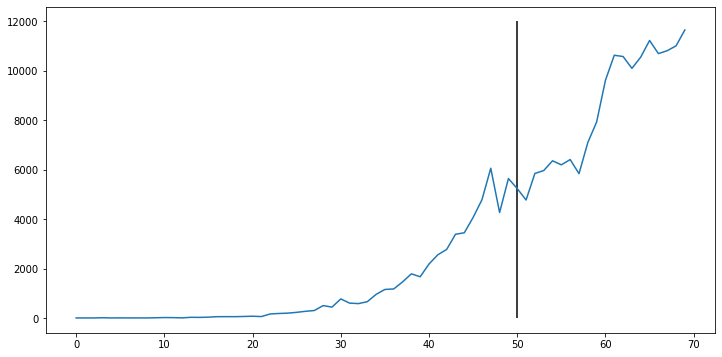

In [233]:
X = np.arange(data_raw.shape[0]).reshape((-1,1))
Y = data_raw.new_cases.values.reshape((-1, 1))

X_train = X[:50]
Y_train = Y[:50]
model = LinearRegression(fit_intercept=True).fit(X_train, np.log(Y_train))
fig, ax = plt.subplots(figsize=(12,6))

ax.plot( Y[:70] )
plt.vlines(50, 0, 12000)

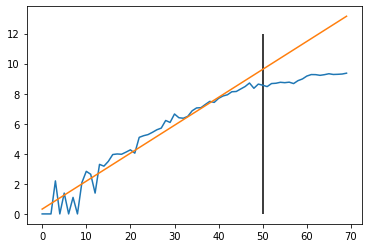

In [232]:
plt.plot( np.log(Y[:70]) )
plt.plot( model.predict(X)[:70] )
plt.vlines(50, 0, 12)

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Шаг Баеса записывается так:                                     $$\mu_{N} = \Sigma_{N} (\Sigma_{0}^{-1} \mu_{0} + \frac{1}{\sigma^{2}} \Phi^{T}t)$$                                                     $$\Sigma_{N} = (\Sigma_{0}^{-1} + \frac{1}{\sigma^{2}} \Phi^{T}\Phi)^{-1}$$                                                            И апостериорное распределение параметров: $$ p(w|t) = N(w|\mu_{N}, \Sigma_{N}) $$, где $\Phi = (\phi_{j}(x_{i}))_{ij}$

В качестве априорного распределения выберем нормальное: $$p(w) = N(w|0, \frac{1}{\alpha} I)$$

In [505]:
def bayesian_update(mu, sigma, x, y, noise):
    assert mu.shape[0] == sigma.shape[0], \
        f'Размерности mu ({mu.shape}) и sigma ({sigma.shape}) не совпадают!'
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (noise ** 2)) * np.dot(x.T, x) )
    mu_n = np.matmul(sigma_n, np.dot(np.linalg.inv(sigma), mu.T) + (1 / (noise ** 2)) * np.matmul(x.T, y))
    return mu_n, sigma_n

Шум дисперсии данных $\sigma$:

In [188]:
np.std(model.predict(X_train) - np.log(Y_train))

0.5960780559466519

In [444]:
def get_bayes_model_params(X, Y, noise=0.6):
    # априорное распределение параметров
    mu_0 = np.zeros(2)
    sigma_0 = 10 * np.identity(2)
    
    mu, sigma = mu_0, sigma_0
    # шаг Байеса
    for x, y in zip(X, Y):
        # добавим bias
        x = np.array([1, x]).reshape((1,-1))
        y = np.array([y])#.reshape((1,1))
        mu, sigma = bayesian_update(mu, sigma, x, y, noise)
    return mu, sigma

In [445]:
mu, sigma = get_bayes_model_params(np.arange(X_train.shape[0]), np.log(Y_train).reshape(-1))

In [446]:
mu, sigma

(array([0.31980931, 0.18598954]), array([[ 2.78749509e-02, -8.44694731e-04],
        [-8.44694731e-04,  3.45021596e-05]]))

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая 2020 года? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

(0.0, 300.0)

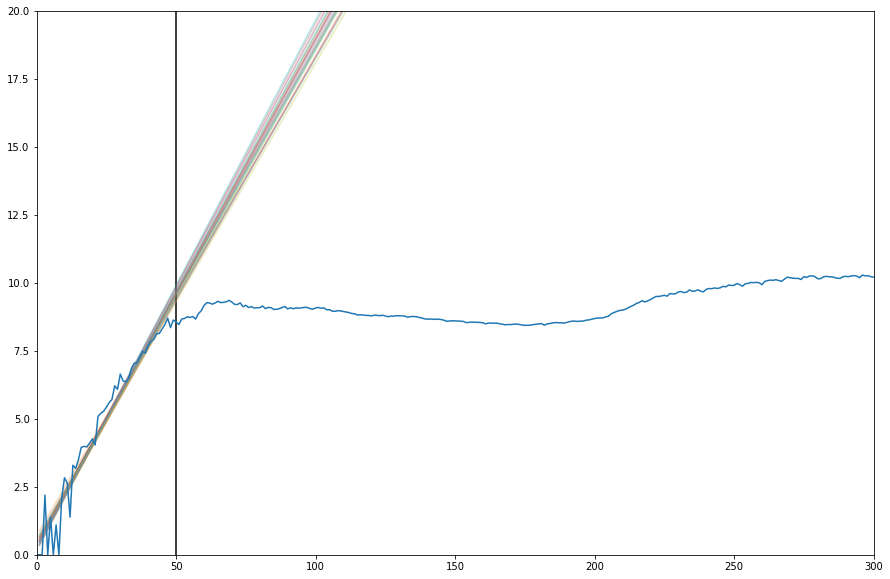

In [447]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
w_sample = np.random.multivariate_normal(mu, sigma, 20)
for w in w_sample:
    x = np.array([[1, i] for i in xs]).reshape((-1, 2))
    ax.plot(xs, np.dot(x, w), alpha=.3)
ax.plot(X.reshape(-1), np.log(Y.reshape(-1)) )
ax.vlines(50, 0, 70)
ax.set_ylim((0, 20))
ax.set_xlim((0, 300))

In [448]:
print(DATE_START + datetime.timedelta(days=59)) # 1 мая
print(DATE_START + datetime.timedelta(days=90)) # 1 июня
print(DATE_START + datetime.timedelta(days=182)) # 1 сент.

2020-05-01
2020-06-01
2020-09-01


In [449]:
for days in [59, 90, 182]:
    w_sample = np.random.multivariate_normal(mu, sigma, 1)
    x = np.array([[1, i] for i in X[:days + 1].reshape(-1)]).reshape((-1, 2))
    sick_qty = np.round(np.sum([np.exp(np.dot(i, w)) for i in x]))
    print(f"к {DATE_START + datetime.timedelta(days=days)} заболеет {sick_qty} чел")

к 2020-05-01 заболеет 531587.0 чел
к 2020-06-01 заболеет 190424044.0 чел
к 2020-09-01 заболеет 7240320714646080.0 чел


(0.0, 100.0)

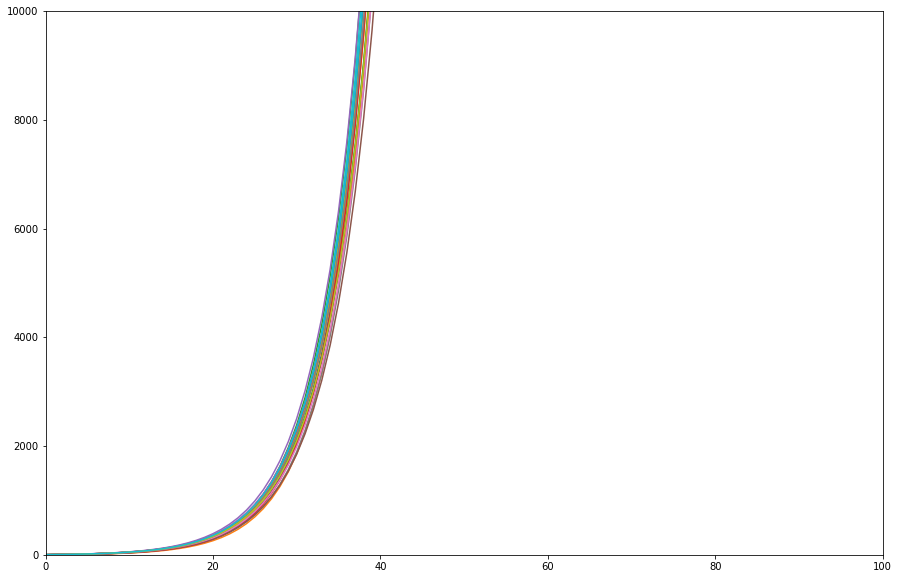

In [450]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

w_sample = np.random.multivariate_normal(mu, sigma, 20)
for w in w_sample:
    x = np.array([[1, i] for i in X.reshape(-1)]).reshape((-1, 2))
    cumulative_predictions = np.cumsum([np.exp(np.dot(w, i)) for i in x])
    ax.plot(X.reshape(-1), cumulative_predictions)
ax.set_ylim((0, 10**4))
ax.set_xlim((0, 100))

### 3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

a) Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии:

Можно предположить, что наша probit функция $\Phi(x) = \int_{-\inf}^{x}\frac{1}{\sqrt(2*\pi)}*e^{\frac{-x^{2}}{2}}dx$ - это функция распределния кол-ва заболевших к дню $x$. Тогда кол-во заболевших в день $y$ можно представить как плотность этой случайной величины, т.е. производную от probit функции: $y = e^{w_{0} + w_{1}*x + w_{2}*x^{2}}$, поэтому $ln(y) = w_{0} + w_{1}*x + w_{2}*x^{2}$, т.е. к модели из прошлого пункта нужно добавить еще одно слагаемое - $x^{2}$

б) Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [513]:
def get_bayes_model_params(X, Y, noise=0.6):
    # априорное распределение параметров
    mu_0 = np.zeros(3)
    sigma_0 = 20 * np.identity(3)
    
    mu, sigma = mu_0, sigma_0
    # шаг Байеса
    for x, y in zip(X, Y):
        # добавим bias
        x = np.array([1, x, x**2]).reshape((1,-1))
        y = np.array([y])#.reshape((1,1))
        mu, sigma = bayesian_update(mu, sigma, x, y, noise)
    return mu, sigma
mu, sigma = get_bayes_model_params(np.arange(X_train.shape[0]), np.log(Y_train).reshape(-1))

(0.0, 300.0)

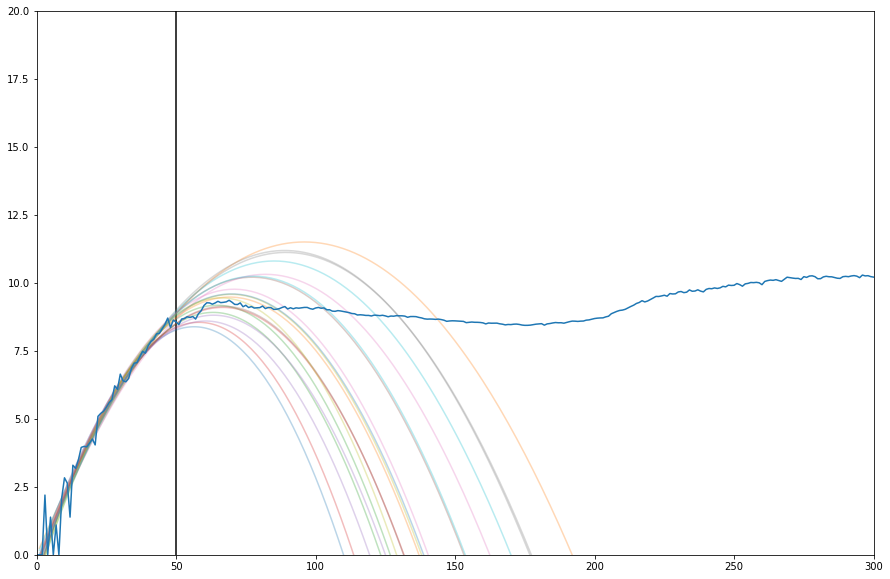

In [514]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
w_sample = np.random.multivariate_normal(mu, sigma, 20)
for w in w_sample:
    x = np.array([[1, i, i**2] for i in xs]).reshape((-1, 3))
    ax.plot(xs, np.dot(x, w), alpha=.3)
ax.plot(X.reshape(-1), np.log(Y.reshape(-1)) )
ax.vlines(50, 0, 70)
ax.set_ylim((0, 20))
ax.set_xlim((0, 300))

(0.0, 300.0)

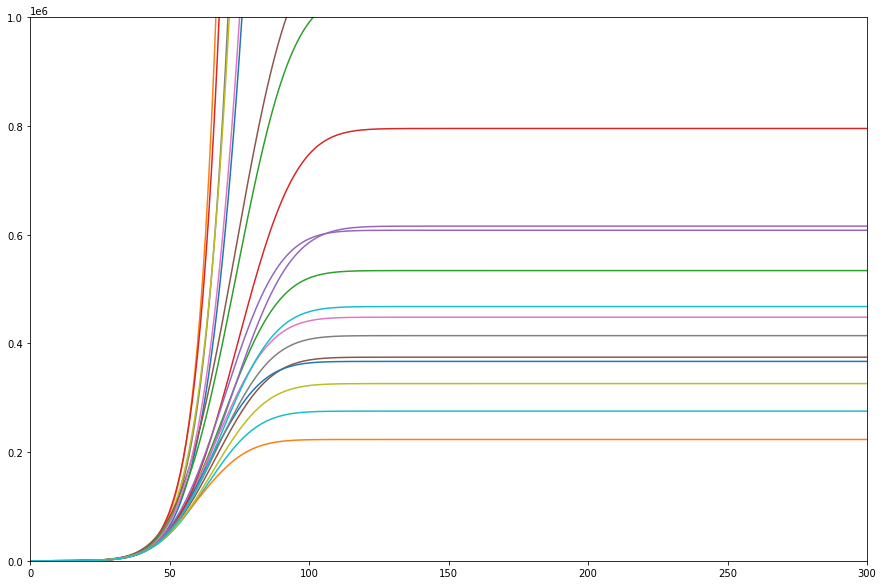

In [515]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

w_sample = np.random.multivariate_normal(mu, sigma, 20)
for w in w_sample:
    x = np.array([[1, i, i**2] for i in X.reshape(-1)]).reshape((-1, 3))
    cumulative_predictions = np.cumsum([np.exp(np.dot(w, i)) for i in x])
    ax.plot(X.reshape(-1), cumulative_predictions)
ax.set_ylim((0, 10**6))
ax.set_xlim((0, 300))

c) Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

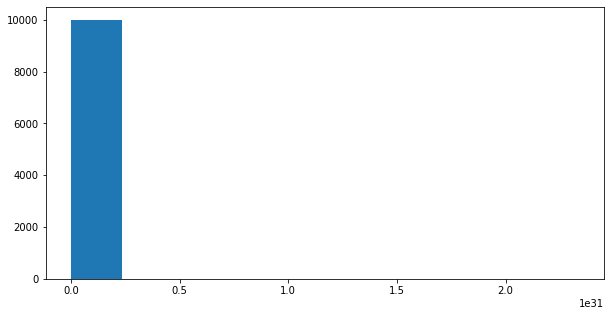

In [530]:
n = 10**4

w_sample = np.random.multivariate_normal(mu, sigma, n)
total_cases = []
for w in w_sample:
    x = np.array([[1, i, i**2] for i in X.reshape(-1)]).reshape((-1, 3))
    cumulative_predictions = np.cumsum([np.exp(np.dot(w, i)) for i in x])
    total_cases.append(cumulative_predictions[-1])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.hist(total_cases);

In [532]:
np.percentile(total_cases, 10)

272810.2199804289

In [533]:
np.percentile(total_cases, 90)

9364573.101460971

In [534]:
np.percentile(total_cases, 98)

150192300.21433598

В самом худшем случае переболеет вся страна, в оптимистичном - 10% процентиль - переболеет около 10 млн граждан